<a href="https://colab.research.google.com/github/nehab2000/healthcare_ml/blob/main/Data_preprocessing_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning-Based Pneumonia Detection from Chest X-Ray Images

**Course:** MIE1517  
**Team Number:** Project Team 4  
**Team Members:** Neha Basra, Domi Nguyen, Sharvani Yadav, Dhruv Thummar

---
## Project Overview

Pneumonia is a serious respiratory infection that affects millions of people worldwide and can be life-threatening if not diagnosed and treated quickly. Chest X-rays are the most common way doctors diagnose pneumonia, but interpreting these images requires expertise and experience. In many parts of the world, there's a shortage of radiologists, which can lead to delayed diagnosis and treatment.

Our project focuses on developing an automated system that can detect pneumonia from chest X-ray images using deep learning. The main goal is to create a model that can assist healthcare professionals by providing accurate and reliable pneumonia detection, especially in areas where medical expertise might be limited.

---

## What We Want to Achieve

The primary objective of this project is to build a deep learning model that can achieve high accuracy in detecting pneumonia from chest X-ray images. Since we're not sure which type of architecture will work best for this specific medical imaging task, we've decided to explore both CNN-based models and Vision Transformer models. This approach will help us understand which architecture is more suitable for pneumonia detection and give us insights into their strengths and weaknesses when applied to medical images.

---

## Our Approach

We'll be implementing and comparing several different architectures:

**CNN Models:**
- EfficientNet - optimized for efficiency and accuracy
- ConvNeXt - a modern CNN that incorporates some transformer design principles

**Vision Transformer Models:**
- ViT (Vision Transformer) - the original transformer approach for images
- Swin Transformer - a hierarchical transformer that's shown great results

All models will be trained on the same dataset and evaluated using the same metrics, so we can make fair comparisons between different approaches.

---

## Explainability

Accuracy alone isn't enough for medical applications. Doctors need to understand and trust the model's decisions. That's why we'll also implement visualization techniques that show which parts of the X-ray image the model is focusing on when making its prediction.

We'll use Grad-CAM for CNN models and attention visualization for transformer models. These techniques will create heatmaps that highlight the areas of the X-ray that contributed most to the model's decision, helping doctors verify and understand the AI's reasoning.


## 1. Environment Setup and Package Installation

### **Python Version** : 3.12.12

Below are the main packages we will use for this project. The code cell installs all of them at once.


In [ ]:
!pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cu129
!pip install scikit-learn matplotlib seaborn opencv-python pillow numpy pandas transformers timm grad-cam plotly kaggle IProgress ipywidgets

In [ ]:
# Importing all necessary libraries

import torch, os, shutil, time, random, timm, gc, cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
from torchvision.ops import sigmoid_focal_loss

# Setting up device for GPU/CPU computation
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print(f'Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
Memory Available: 15.92 GB


We're training our models using a 16 GB GPU. Smaller GPUs might run into memory issues during training, and we haven't optimized the code specifically for CPU execution.


## 2. Dataset Overview and Visualization

We'll be using three different pneumonia detection datasets from Kaggle to train and evaluate our models. Each dataset brings unique characteristics that will help us build a robust pneumonia detection system.

### Dataset Details:

**1. Chest X-Ray Images (Pneumonia) - Paul Timothy Mooney**
- **Link:** https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- **Size:** 5,856 images
- **Positive samples:** 4,273
- **Negative samples:** 1,583

**2. RSNA Pneumonia Processed Dataset - Tapendu**
- **Link:** https://www.kaggle.com/datasets/iamtapendu/rsna-pneumonia-processed-dataset
- **Size:** 26,684 images
- **Positive samples:** 6,012
- **Negative samples:** 20,672

**3. CheXpert Dataset - Ashery**
- **Link:** https://www.kaggle.com/datasets/ashery/chexpert
- **Size:** 224,316 images
- **Positive samples:** 6,047
- **Negative samples:** 3,025

### Training Strategy:
We're combining the first two datasets for training because the first dataset only contains chest X-rays from children aged 1-5 years, while the RSNA dataset includes patients of various ages, giving us a more diverse age distribution for training. Using last two datasets for training would provide more data, but it would introduce bias in our testing since we'd be testing on the first dataset where X-Ray images are associated with children aged 1-5 years. By keeping CheXpert as a completely separate hold-out test set, we can better evaluate how well our models generalize to unseen data from a different source and patient population.

**Acknowledgments:** Thanks to all dataset creators for making these valuable medical imaging datasets publicly available for research purposes.


### Downloading all the datasets

In [ ]:
def download_kaggle_dataset(dataset_name: str, download_path: str) -> None:
    """
    Downloads and extracts a Kaggle dataset, removing the zip file after extraction.

    Input:
    dataset_name (str) - Kaggle dataset identifier (e.g., 'username/dataset-name')
    download_path (str) - Directory to download and extract dataset

    Output: None
    """
    # Setting up the env variables
    os.environ['KAGGLE_USERNAME'] = 'neha2000'
    os.environ['KAGGLE_KEY'] = 'c7ffc7d2469c6247681ee8f'

    # Initialize Kaggle API
    api = KaggleApi()
    api.authenticate()

    # Create download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download dataset
    api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# Download all three datasets
print("Downloading Chest X-Ray Pneumonia dataset...")
download_kaggle_dataset('paultimothymooney/chest-xray-pneumonia', './datasets/chest-xray-pneumonia/')

print("Downloading RSNA Pneumonia Processed dataset...")
download_kaggle_dataset('iamtapendu/rsna-pneumonia-processed-dataset', './datasets/rsna-pneumonia/')

print("Downloading CheXpert dataset...")
download_kaggle_dataset('ashery/chexpert', './datasets/chexpert/')


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Dataset URL: https://www.kaggle.com/datasets/iamtapendu/rsna-pneumonia-processed-dataset
Dataset URL: https://www.kaggle.com/datasets/ashery/chexpert




### Processing First Dataset (Chest X-Ray Pneumonia)

We'll process the first dataset by preserving its existing train/test/val folder structure. This is crucial because this dataset contains multiple X-ray images from the same patients. If we were to mix and randomly split these images, we would risk data leakage - where images from the same patient could appear in both training and testing sets, leading to overly optimistic performance metrics. To avoid this issue, we maintain the original splits while reorganizing the folders to our standardized naming convention.

Before processing, the **Chest X-Ray Pneumonia** dataset is organized with the following folder structure:

```
chest_xray/
  train/
    NORMAL/
      img1.jpeg
      img2.jpeg
      ...
    PNEUMONIA/
      img3.jpeg
      img4.jpeg
      ...
  val/
    NORMAL/
      img5.jpeg
      ...
    PNEUMONIA/
      img6.jpeg
      ...
  test/
    NORMAL/
      img7.jpeg
      ...
    PNEUMONIA/
      img8.jpeg
      ...
```

The 'PNEUMONIA' folders will be renamed to 'positive' and 'NORMAL' folders will be renamed to 'negative' in respective train, val and test folders. Additionally, we'll assign unique random names based on timestamp to each image to avoid any naming conflicts when we merge with other datasets.

In [ ]:
# Global variable for final dataset path
FINAL_DATASET_PATH = './datasets/combined_dataset/'

# Source path for chest x-ray dataset
source_path = './datasets/chest-xray-pneumonia/chest_xray/'

# Create final dataset directory structure with train/test/val splits
for split in ['train', 'test', 'val']:
    os.makedirs(f'{FINAL_DATASET_PATH}/{split}/positive', exist_ok=True)
    os.makedirs(f'{FINAL_DATASET_PATH}/{split}/negative', exist_ok=True)

# Initialize counters for tracking processed images
total_positive = 0
total_negative = 0

# Process each split (train, test, val)
for split in ['train', 'test', 'val']:
    split_path = os.path.join(source_path, split)

    # Check if split directory exists
    if os.path.exists(split_path):
        # Process PNEUMONIA images (positive cases)
        pneumonia_path = os.path.join(split_path, 'PNEUMONIA')
        if os.path.exists(pneumonia_path):
            # Iterate through all pneumonia images
            for img_file in os.listdir(pneumonia_path):
                # Check if file is an image
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Generate unique filename using timestamp and random number
                    timestamp = str(int(time.time() * 1000000))  # microsecond precision
                    random_num = random.randint(1000, 9999)
                    file_extension = os.path.splitext(img_file)[1]
                    unique_name = f'pos_{timestamp}_{random_num}{file_extension}'

                    # Copy image to positive directory in respective split
                    src = os.path.join(pneumonia_path, img_file)
                    dst = os.path.join(FINAL_DATASET_PATH, split, 'positive', unique_name)
                    shutil.copy2(src, dst)
                    total_positive += 1

        # Process NORMAL images (negative cases)
        normal_path = os.path.join(split_path, 'NORMAL')
        if os.path.exists(normal_path):
            # Iterate through all normal images
            for img_file in os.listdir(normal_path):
                # Check if file is an image
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Generate unique filename using timestamp and random number
                    timestamp = str(int(time.time() * 1000000))  # microsecond precision
                    random_num = random.randint(1000, 9999)
                    file_extension = os.path.splitext(img_file)[1]
                    unique_name = f'neg_{timestamp}_{random_num}{file_extension}'

                    # Copy image to negative directory in respective split
                    src = os.path.join(normal_path, img_file)
                    dst = os.path.join(FINAL_DATASET_PATH, split, 'negative', unique_name)
                    shutil.copy2(src, dst)
                    total_negative += 1

# Display dataset statistics
print("=== Chest X-Ray Dataset Statistics ===")
print(f"Total Positive samples (Pneumonia): {total_positive}")
print(f"Total Negative samples (Normal): {total_negative}")
print(f"Total images: {total_positive + total_negative}")

=== Chest X-Ray Dataset Statistics ===
Total Positive samples (Pneumonia): 4273
Total Negative samples (Normal): 1583
Total images: 5856


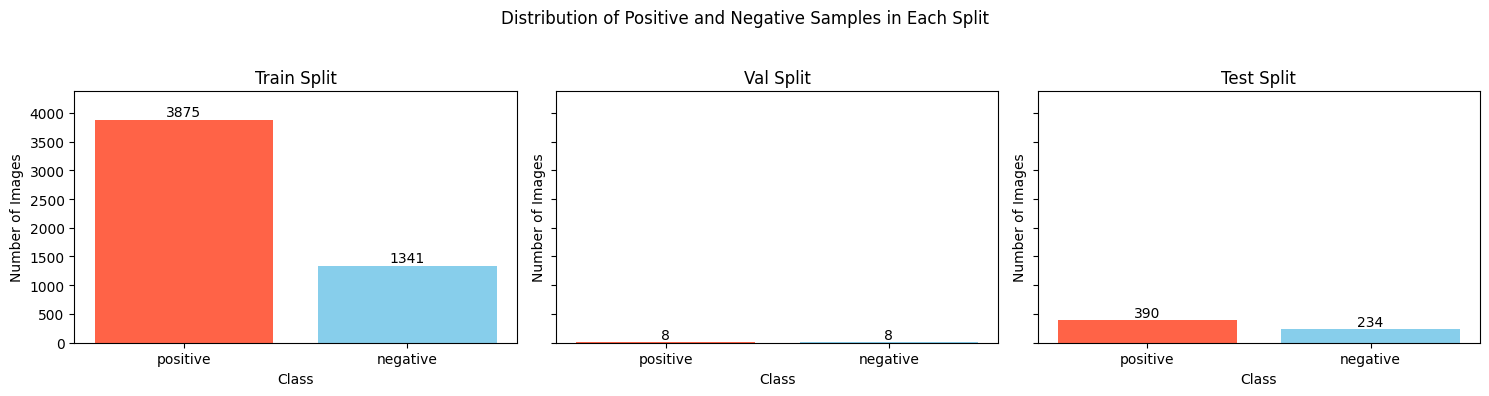

In [ ]:
# Distibution of images in train, val and test split
# Count images in each class for each split
splits = ['train', 'val', 'test']
class_names = ['positive', 'negative']
counts = {split: {cls: 0 for cls in class_names} for split in splits}

for split in splits:
    for cls in class_names:
        dir_path = os.path.join(FINAL_DATASET_PATH, split, cls)
        if os.path.exists(dir_path):
            counts[split][cls] = len([
                f for f in os.listdir(dir_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for idx, split in enumerate(splits):
    axes[idx].bar(class_names, [counts[split][cls] for cls in class_names], color=['tomato', 'skyblue'])
    axes[idx].set_title(f'{split.capitalize()} Split')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_ylim(0, max(total_positive, total_negative) + 100)
    for i, cls in enumerate(class_names):
        axes[idx].text(i, counts[split][cls] + 10, str(counts[split][cls]), ha='center', va='bottom')

plt.suptitle('Distribution of Positive and Negative Samples in Each Split')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Processing Second Dataset (RSNA Pneumonia Processed)

The RSNA dataset has a different structure compared to the first dataset. It contains processed PNG images in separate train and test folders, along with metadata CSV files that contain the labels and patient information.

An important consideration for this dataset is that we're only using unique patient IDs. When we examined the dataset, we discovered that the same patient images were repeated multiple times, with approximately 3,000 duplicate occurrences in total. This repetition exists because the original RSNA dataset was designed for bounding box detection tasks, where the same image could be used multiple times with different bounding box annotations.

In our binary classification task (pneumonia vs. normal), including these duplicate images would artificially inflate our validation or test metrics, leading to overly optimistic performance estimates. To avoid this data leakage issue, we remove duplicate patient IDs from the CSV file during processing, keeping only the first occurrence of each unique patient.

The RSNA dataset includes chest X-ray images of various diseases besides pneumonia labeled as non-pneumonia X-rays. For our project, we have chosen to include only images explicitly labeled as "normal" in the metadata as negative samples. We observed that X-rays from other non-pneumonia diseases often appear visually similar to pneumonia cases, making it challenging to accurately distinguish between them using only image data (without other features). During initial experiments, including these 'other disease' images led to a plateau in model performance, with accuracy not improving beyond a certain point. For this reason, we decided to omit these ambiguous X-rays and use only clear normal cases as negatives, ensuring a more reliable basis for model learning and evaluation.

We'll first process this dataset separately by reading the metadata to determine which images are positive (pneumonia) and which are negative (normal), then organize them into a temporary folder structure. This intermediate step allows us to properly organize the RSNA data before merging it with the first dataset.

We're using the same naming convention with unique timestamps to avoid any file naming conflicts. Note that we're not using test images provided in this dataset as there are no labels available for them.

In [ ]:
# RSNA dataset base path
rsna_path = './datasets/rsna-pneumonia/'

# Temporary path for processed RSNA dataset
RSNA_PROCESSED_PATH = './datasets/rsna_processed/'

# Create directory structure for processed RSNA dataset
os.makedirs(f'{RSNA_PROCESSED_PATH}/positive', exist_ok=True)
os.makedirs(f'{RSNA_PROCESSED_PATH}/negative', exist_ok=True)

# Initialize counters
positive_count = 0
negative_count = 0

# Construct paths
metadata_path = os.path.join(rsna_path, "stage2_train_metadata.csv")
images_path = os.path.join(rsna_path, "Training/Images")

# Check if both metadata and images exist
if os.path.exists(metadata_path) and os.path.exists(images_path):
    # Read metadata CSV file
    df = pd.read_csv(metadata_path)

    # Remove duplicate patientId rows, keeping the first occurrence
    df = df.drop_duplicates(subset='patientId', keep='first')

    # Check if Target column exists in metadata
    if 'Target' in df.columns:
        # Process each row in metadata
        for idx, row in df.iterrows():
            patient_id = row['patientId']
            target = row['Target']  # 1 for pneumonia, 0 for normal
            lung_class = row['class'] # "Normal" for X-rays without any disease,
                                      # "No Lung Opacity / Not Normal" for other diseases, "Lung Opacity" for pneumonia disease

            # Construct source image path
            img_file = f"{patient_id}.png"
            src_path = os.path.join(images_path, img_file)

            # Check if image file exists
            if os.path.exists(src_path):
                # Generate unique filename with timestamp and random number
                timestamp = str(int(time.time() * 1000000))  # microsecond precision
                random_num = random.randint(1000, 9999)

                # Process based on target label
                if target == 1:  # Pneumonia case (positive)
                    unique_name = f'pos_{timestamp}_{random_num}.png'
                    dst_path = os.path.join(f'{RSNA_PROCESSED_PATH}/positive', unique_name)
                    shutil.copy2(src_path, dst_path)  # Copy to positive folder
                    positive_count += 1
                elif target == 0 and lung_class == "Normal":  # Normal case (negative)
                    unique_name = f'neg_{timestamp}_{random_num}.png'
                    dst_path = os.path.join(f'{RSNA_PROCESSED_PATH}/negative', unique_name)
                    shutil.copy2(src_path, dst_path)  # Copy to negative folder
                    negative_count += 1
    else:
        print(f"Target column not found in {metadata_path}, skipping processing")
else:
    print(f"Metadata file or images folder not found.")

# Display final statistics
print("=== RSNA Dataset Statistics ===")
print(f"Total Positive samples: {positive_count}")
print(f"Total Negative samples: {negative_count}")
print(f"Total images processed: {positive_count + negative_count}")

=== RSNA Dataset Statistics ===
Total Positive samples: 6012
Total Negative samples: 8851
Total images processed: 14863


#### Displaying X-rays for Pneumonia, Normal and Not normal Cases

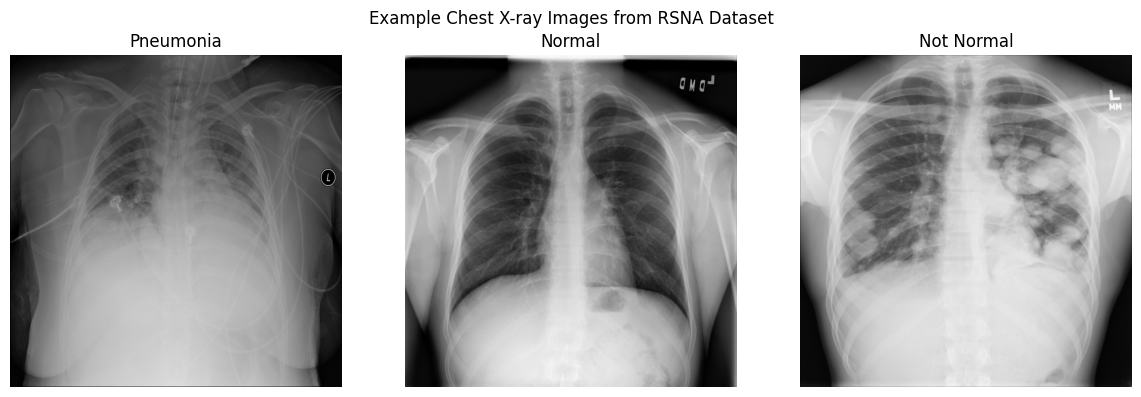

In [ ]:
# Paths
metadata_path = os.path.join(rsna_path, "stage2_train_metadata.csv")
images_path = os.path.join(rsna_path, "Training/Images")

# Read metadata
df = pd.read_csv(metadata_path)

# Remove duplicate patientId rows, keeping the first occurrence
df = df.drop_duplicates(subset='patientId', keep='first')

# Find one sample for each class
sample_rows = {
    'Pneumonia': df[df['Target'] == 1].iloc[0],
    'Normal': df[(df['Target'] == 0) & (df['class'] == "Normal")].iloc[0],
    'Not Normal': df[(df['Target'] == 0) & (df['class'] == "No Lung Opacity / Not Normal")].iloc[2] # Chosen 2nd index to display better example
}

# Plot images
plt.figure(figsize=(12, 4))
for idx, (label, row) in enumerate(sample_rows.items()):
    patient_id = row['patientId']
    img_path = os.path.join(images_path, f"{patient_id}.png")
    img = Image.open(img_path)
    plt.subplot(1, 3, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.suptitle('Example Chest X-ray Images from RSNA Dataset')
plt.tight_layout()
plt.show()

The figure above shows representative chest X-ray images from the RSNA dataset. On the left, the pneumonia case is characterized by large white areas in the lungs, indicating fluid accumulation that blocks X-rays. In the center, the normal X-ray shows clear lungs filled with air, resulting in darker regions. The rightmost image, labeled "Not Normal," displays a mix of clear and opaque areas—some regions are filled with fluid (white), while others remain clear. Although these "Not Normal" cases are technically negative for pneumonia, their appearance can closely resemble pneumonia cases, making them difficult for a model to distinguish without additional clinical information. For this reason, we chose to exclude these ambiguous cases from our negative class. While a third label might be appropriate for such images, this is beyond the scope of our current project and could be explored in future work.

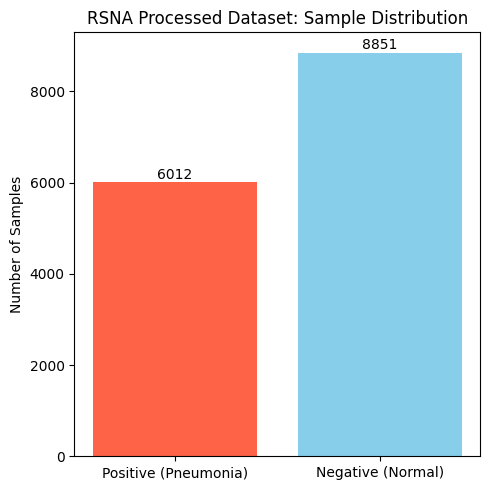

In [ ]:
# Distribution of positive and negative images
# Data for histogram
labels = ['Positive (Pneumonia)', 'Negative (Normal)']
counts = [positive_count, negative_count]
colors = ['tomato', 'skyblue']

plt.figure(figsize=(5, 5))
bars = plt.bar(labels, counts, color=colors)

# Annotate bars with counts
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count),
             ha='center', va='bottom', fontsize=10)

plt.title('RSNA Processed Dataset: Sample Distribution')
plt.ylabel('Number of Samples')
# plt.ylim(0, max(counts) + 200)
plt.tight_layout()
plt.show()

### Processing Third Dataset (CheXpert - Hold-out Test Set)

The CheXpert dataset serves as our hold-out test set for final model evaluation. Unlike our training datasets, CheXpert contains both frontal and lateral chest X-ray images. Since our training data only includes frontal X-rays, evaluating on lateral images could lead to misleadingly low accuracy due to differences in anatomical presentation. To ensure a fair and consistent evaluation, we filter the CheXpert dataset to include only frontal X-rays. This approach aligns the test set with the data distribution seen during training and helps us better assess the model’s true generalization performance.

We process the CheXpert metadata to identify positive (pneumonia) and negative (normal) cases, copy the corresponding frontal images to a standardized folder structure, and use unique filenames to avoid conflicts. Uncertain labels and lateral images are excluded from evaluation.

In [ ]:
def process_chexpert_dataset(img_dataset_path: str, csv_path: str, output_path: str) -> tuple[int, int]:
    """
    Processes CheXpert dataset and copies images to organized directory structure.

    Input: dataset_path (str) - Base path to Images folder
           csv_path (str) - Path of CSV metadata file
           output_path (str) - Output directory path
    Output: tuple[int, int] - (positive_count, negative_count)
    """
    # Initialize counters
    positive_count = 0
    negative_count = 0

    # Read CSV file
    if not os.path.exists(csv_path):
        print(f"CSV file not found: {csv_path}")
        return 0, 0

    df = pd.read_csv(csv_path)

    # Extracting only frontal X-rays
    df = df[df['Frontal/Lateral'] == 'Frontal']

    # Process each row
    for idx, row in df.iterrows():
        img_path = row["Path"]
        pneumonia_label = row["Pneumonia"]

        # Skip uncertain cases (-1.0 or empty cells)
        if pneumonia_label not in [0.0, 1.0]:
            continue

        # Fix path by removing 'CheXpert-v1.0-small/train' and 'CheXpert-v1.0-small/train' prefix available in CSV file
        # if we do not fix this then path name would be like this, ./datasets/chexpert/train/CheXpert-v1.0-small/train/patient00012/study3/view1_frontal.jpg
        if 'CheXpert-v1.0-small/train' in img_path:
            img_path = img_path.replace('CheXpert-v1.0-small/train/', '')
        if 'CheXpert-v1.0-small/valid' in img_path:
            img_path = img_path.replace('CheXpert-v1.0-small/valid/', '')


        # Construct full image path
        full_img_path = os.path.join(img_dataset_path, img_path.lstrip('./'))

        if os.path.exists(full_img_path):
            # Generate unique filename
            timestamp = str(int(time.time() * 1000000))
            random_num = random.randint(1000, 9999)
            file_extension = os.path.splitext(img_path)[1]

            # Copy based on label
            if pneumonia_label == 1.0:  # Positive case
                unique_name = f'pos_{timestamp}_{random_num}{file_extension}'
                dst_path = os.path.join(f'{output_path}/positive', unique_name)
                shutil.copy2(full_img_path, dst_path)
                positive_count += 1
            else:  # Negative case
                unique_name = f'neg_{timestamp}_{random_num}{file_extension}'
                dst_path = os.path.join(f'{output_path}/negative', unique_name)
                shutil.copy2(full_img_path, dst_path)
                negative_count += 1

    return positive_count, negative_count

# Setup paths
holdout_dataset_path = './datasets/holdout_dataset/'

# Create holdout dataset directories
os.makedirs(f'{holdout_dataset_path}/positive', exist_ok=True)
os.makedirs(f'{holdout_dataset_path}/negative', exist_ok=True)

# Process CheXpert dataset
pos_count, neg_count = process_chexpert_dataset(
    img_dataset_path="./datasets/chexpert/train",
    csv_path='./datasets/chexpert/train.csv',
    output_path=holdout_dataset_path,
)

pos_count_test, neg_count_test = process_chexpert_dataset(
    img_dataset_path="./datasets/chexpert/valid",
    csv_path='./datasets/chexpert/valid.csv',
    output_path=holdout_dataset_path,
)

# Display results
print("=== CheXpert Dataset Statistics ===")
print(f"Positive samples: {pos_count+pos_count_test}")
print(f"Negative samples: {neg_count+neg_count_test}")
print(f"Total images processed: {pos_count + neg_count + pos_count_test + neg_count_test}")

=== CheXpert Dataset Statistics ===
Positive samples: 4683
Negative samples: 2069
Total images processed: 6752


#### Displaying Frontal and lateral X-rays

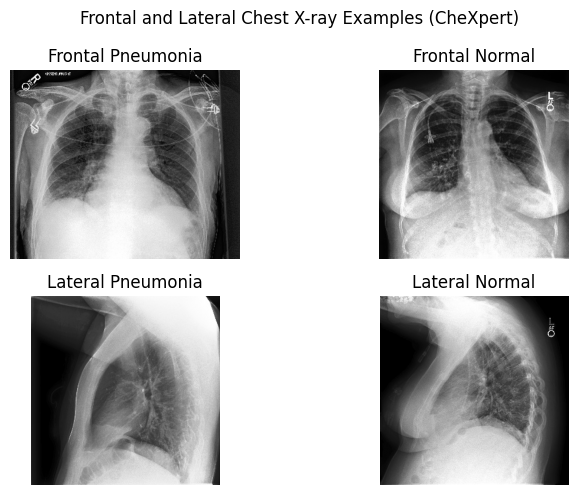

In [ ]:
# Paths
chexpert_csv = './datasets/chexpert/train.csv'
chexpert_img_root = './datasets/chexpert/train'

# Read metadata
df = pd.read_csv(chexpert_csv)

# Filter for certain labels only
df = df[df['Pneumonia'].isin([0.0, 1.0])]

# Find one example for each category
samples = {
    'Frontal Pneumonia': df[(df['Frontal/Lateral'] == 'Frontal') & (df['Pneumonia'] == 1.0)].iloc[0],
    'Frontal Normal': df[(df['Frontal/Lateral'] == 'Frontal') & (df['Pneumonia'] == 0.0)].iloc[0],
    'Lateral Pneumonia': df[(df['Frontal/Lateral'] == 'Lateral') & (df['Pneumonia'] == 1.0)].iloc[0],
    'Lateral Normal': df[(df['Frontal/Lateral'] == 'Lateral') & (df['Pneumonia'] == 0.0)].iloc[0],
}

# Plot images
plt.figure(figsize=(8, 5))
for idx, (label, row) in enumerate(samples.items()):
    img_path = row['Path']
    # Fix path if necessary
    if 'CheXpert-v1.0-small/train' in img_path:
        img_path = img_path.replace('CheXpert-v1.0-small/train/', '')
    full_img_path = os.path.join(chexpert_img_root, img_path.lstrip('./'))
    img = Image.open(full_img_path)
    plt.subplot(2, 2, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.suptitle('Frontal and Lateral Chest X-ray Examples (CheXpert)')
plt.tight_layout()
plt.show()

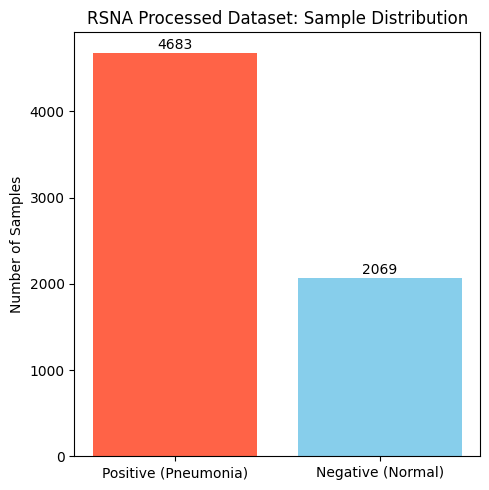

In [ ]:
# Distribution of positive and negative images
# Data for histogram
labels = ['Positive (Pneumonia)', 'Negative (Normal)']
counts = [pos_count+pos_count_test, neg_count+neg_count_test]
colors = ['tomato', 'skyblue']

plt.figure(figsize=(5, 5))
bars = plt.bar(labels, counts, color=colors)

# Annotate bars with counts
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count),
             ha='center', va='bottom', fontsize=10)

plt.title('RSNA Processed Dataset: Sample Distribution')
plt.ylabel('Number of Samples')
# plt.ylim(0, max(counts) + 200)
plt.tight_layout()
plt.show()

### Dataset Balancing

After processing the Chest X-Ray and RSNA datasets, we need to merge them while maintaining a consistent class distribution across train/validation/test splits. The final combined dataset is nearly balanced, so there is no need for under-sampling or over-sampling techniques.

**Current Dataset Statistics:**
- **Chest X-Ray Dataset:**  
  - Positive (Pneumonia): 4,273  
  - Negative (Normal): 1,583  
  - Total: 5,856
- **RSNA Dataset:**  
  - Positive: 6,012  
  - Negative: 8,851  
  - Total: 14,863
- **Combined:**  
  - Positive: 10,285  
  - Negative: 10,434  
  - Combined Ratio (Negative:Positive): 1.01:1

To create our final dataset, we allocated 80% of images to training, 10% to validation, and 10% to testing, maintaining this balanced ratio in each split. The target split sizes and class distributions are as follows:

**Target Split Sizes:**
- **Training:** 16,575 images (80%)
- **Validation:** 2,071 images (10%)
- **Testing:** 2,073 images (10%)

**Target Class Distribution:**
- **Training:** 8,227 positive, 8,348 negative (Ratio: 1.01:1)
- **Validation:** 1,028 positive, 1,043 negative (Ratio: 1.01:1)
- **Testing:** 1,029 positive, 1,044 negative (Ratio: 1.01:1)

The Chest X-Ray dataset is already in our combined folder with its original train/val/test split. We'll add the required number of RSNA images to each split to achieve our target distribution:

**RSNA Images to Add:**
- **Training:** 4,352 positive, 7,007 negative
- **Validation:** 1,020 positive, 1,035 negative
- **Testing:** 639 positive, 810 negative

This approach ensures that each split is balanced and representative, providing a solid foundation for model training and evaluation. Since the dataset is already balanced, we do not apply any additional sampling strategies.

In [ ]:
# Set random seed for reproducibility
random.seed(3454504)
# Defining Split
TRAIN = 0.8
TEST = 0.1
VAL = 1-TRAIN-TEST

# Paths
COMBINED_DATASET_PATH = './datasets/combined_dataset/'
RSNA_PROCESSED_PATH = './datasets/rsna_processed/'

# Function to count images in a directory
def count_images(directory):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# First, count existing images in combined dataset (Chest X-Ray)
chest_counts = {
    'train': {
        'positive': count_images(os.path.join(COMBINED_DATASET_PATH, 'train', 'positive')),
        'negative': count_images(os.path.join(COMBINED_DATASET_PATH, 'train', 'negative'))
    },
    'val': {
        'positive': count_images(os.path.join(COMBINED_DATASET_PATH, 'val', 'positive')),
        'negative': count_images(os.path.join(COMBINED_DATASET_PATH, 'val', 'negative'))
    },
    'test': {
        'positive': count_images(os.path.join(COMBINED_DATASET_PATH, 'test', 'positive')),
        'negative': count_images(os.path.join(COMBINED_DATASET_PATH, 'test', 'negative'))
    }
}

# Print existing counts
print("=== Existing Images in Combined Dataset (Chest X-Ray) ===")
chest_total_positive = 0
chest_total_negative = 0
for split, counts in chest_counts.items():
    print(f"{split.upper()}: Positive={counts['positive']}, Negative={counts['negative']}")
    chest_total_positive += counts['positive']
    chest_total_negative += counts['negative']

print(f"TOTAL: Positive={chest_total_positive}, Negative={chest_total_negative}")

# Count RSNA images
rsna_positive = count_images(os.path.join(RSNA_PROCESSED_PATH, 'positive'))
rsna_negative = count_images(os.path.join(RSNA_PROCESSED_PATH, 'negative'))

print(f"\n=== Available RSNA Images ===")
print(f"Positive: {rsna_positive}")
print(f"Negative: {rsna_negative}")


# Calculate the combined ratio
total_positive = chest_total_positive + rsna_positive
total_negative = chest_total_negative + rsna_negative
combined_ratio = total_negative / total_positive if total_positive > 0 else 0
print(f"\n=== Combined Dataset Ratio ===")
print(f"Total Positive: {total_positive}")
print(f"Total Negative: {total_negative}")
print(f"Combined Ratio (Negative:Positive): {combined_ratio:.2f}:1")

# Calculate total images and split sizes
total_images = total_positive + total_negative
train_size = int(total_images * TRAIN)
val_size = int(total_images * TEST)
test_size = total_images - train_size - val_size

print(f"\n=== Target Split Sizes ===")
print(f"Train: {train_size} images ({train_size/total_images:.1%})")
print(f"Validation: {val_size} images ({val_size/total_images:.1%})")
print(f"Test: {test_size} images ({test_size/total_images:.1%})")

# Calculate how many images we need in each split while maintaining the ratio
train_positive = int(train_size / (combined_ratio + 1))
train_negative = train_size - train_positive

val_positive = int(val_size / (combined_ratio + 1))
val_negative = val_size - val_positive

test_positive = int(test_size / (combined_ratio + 1))
test_negative = test_size - test_positive

print(f"\n=== Target Class Distribution ===")
print(f"Train: Positive={train_positive}, Negative={train_negative}, Ratio={train_negative/train_positive:.2f}:1")
print(f"Validation: Positive={val_positive}, Negative={val_negative}, Ratio={val_negative/val_positive:.2f}:1")
print(f"Test: Positive={test_positive}, Negative={test_negative}, Ratio={test_negative/test_positive:.2f}:1")

# Calculate how many RSNA images to add to each split
to_add = {
    'train': {
        'positive': max(0, train_positive - chest_counts['train']['positive']),
        'negative': max(0, train_negative - chest_counts['train']['negative'])
    },
    'val': {
        'positive': max(0, val_positive - chest_counts['val']['positive']),
        'negative': max(0, val_negative - chest_counts['val']['negative'])
    },
    'test': {
        'positive': max(0, test_positive - chest_counts['test']['positive']),
        'negative': max(0, test_negative - chest_counts['test']['negative'])
    }
}

print(f"\n=== RSNA Images to Add ===")
for split, counts in to_add.items():
    print(f"{split.upper()}: Add {counts['positive']} positive, {counts['negative']} negative")


=== Existing Images in Combined Dataset (Chest X-Ray) ===
TRAIN: Positive=3875, Negative=1341
VAL: Positive=8, Negative=8
TEST: Positive=390, Negative=234
TOTAL: Positive=4273, Negative=1583

=== Available RSNA Images ===
Positive: 6012
Negative: 8851

=== Combined Dataset Ratio ===
Total Positive: 10285
Total Negative: 10434
Combined Ratio (Negative:Positive): 1.01:1

=== Target Split Sizes ===
Train: 16575 images (80.0%)
Validation: 2071 images (10.0%)
Test: 2073 images (10.0%)

=== Target Class Distribution ===
Train: Positive=8227, Negative=8348, Ratio=1.01:1
Validation: Positive=1028, Negative=1043, Ratio=1.01:1
Test: Positive=1029, Negative=1044, Ratio=1.01:1

=== RSNA Images to Add ===
TRAIN: Add 4352 positive, 7007 negative
VAL: Add 1020 positive, 1035 negative
TEST: Add 639 positive, 810 negative


In [ ]:
# Function to randomly select and move images
def select_and_move_images(source_dir, dest_dir, count):
    # Get all image files
    all_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"  Available {len(all_files)} images")
    # Randomly select the required number of files
    selected_files = random.sample(all_files, min(count, len(all_files)))

    # Move each selected file
    moved_count = 0
    for file in selected_files:
        src_path = os.path.join(source_dir, file)
        dst_path = os.path.join(dest_dir, file)
        shutil.move(src_path, dst_path)
        moved_count += 1

    return moved_count

# Distribute RSNA images to maintain the target ratio
for split, counts in to_add.items():
    print(f"\nAdding images to {split} split:")

    # Add positive images
    pos_source = os.path.join(RSNA_PROCESSED_PATH, 'positive')
    pos_dest = os.path.join(COMBINED_DATASET_PATH, split, 'positive')
    pos_added = select_and_move_images(pos_source, pos_dest, counts['positive'])
    print(f"  Added {pos_added} positive images")

    # Add negative images
    neg_source = os.path.join(RSNA_PROCESSED_PATH, 'negative')
    neg_dest = os.path.join(COMBINED_DATASET_PATH, split, 'negative')
    neg_added = select_and_move_images(neg_source, neg_dest, counts['negative'])
    print(f"  Added {neg_added} negative images")

# Verify final distribution
final_counts = {
    'train': {
        'positive': count_images(os.path.join(COMBINED_DATASET_PATH, 'train', 'positive')),
        'negative': count_images(os.path.join(COMBINED_DATASET_PATH, 'train', 'negative'))
    },
    'val': {
        'positive': count_images(os.path.join(COMBINED_DATASET_PATH, 'val', 'positive')),
        'negative': count_images(os.path.join(COMBINED_DATASET_PATH, 'val', 'negative'))
    },
    'test': {
        'positive': count_images(os.path.join(COMBINED_DATASET_PATH, 'test', 'positive')),
        'negative': count_images(os.path.join(COMBINED_DATASET_PATH, 'test', 'negative'))
    }
}

# Print final statistics
print("\n=== Final Dataset Distribution ===")
total_pos = 0
total_neg = 0

for split, counts in final_counts.items():
    pos = counts['positive']
    neg = counts['negative']
    ratio = neg / pos if pos > 0 else 0

    print(f"{split.upper()}: Positive={pos}, Negative={neg}, Ratio={ratio:.2f}:1")

    total_pos += pos
    total_neg += neg

overall_ratio = total_neg / total_pos if total_pos > 0 else 0
print(f"\nOVERALL: Positive={total_pos}, Negative={total_neg}, Ratio={overall_ratio:.2f}:1")
print(f"Total images: {total_pos + total_neg}")


Adding images to train split:
  Available 6012 images
  Added 4352 positive images
  Available 8851 images
  Added 7007 negative images

Adding images to val split:
  Available 1660 images
  Added 1020 positive images
  Available 1844 images
  Added 1035 negative images

Adding images to test split:
  Available 640 images
  Added 639 positive images
  Available 809 images
  Added 809 negative images

=== Final Dataset Distribution ===
TRAIN: Positive=8227, Negative=8348, Ratio=1.01:1
VAL: Positive=1028, Negative=1043, Ratio=1.01:1
TEST: Positive=1029, Negative=1043, Ratio=1.01:1

OVERALL: Positive=10284, Negative=10434, Ratio=1.01:1
Total images: 20718


####  Plot for data distribution in train, val and test folders

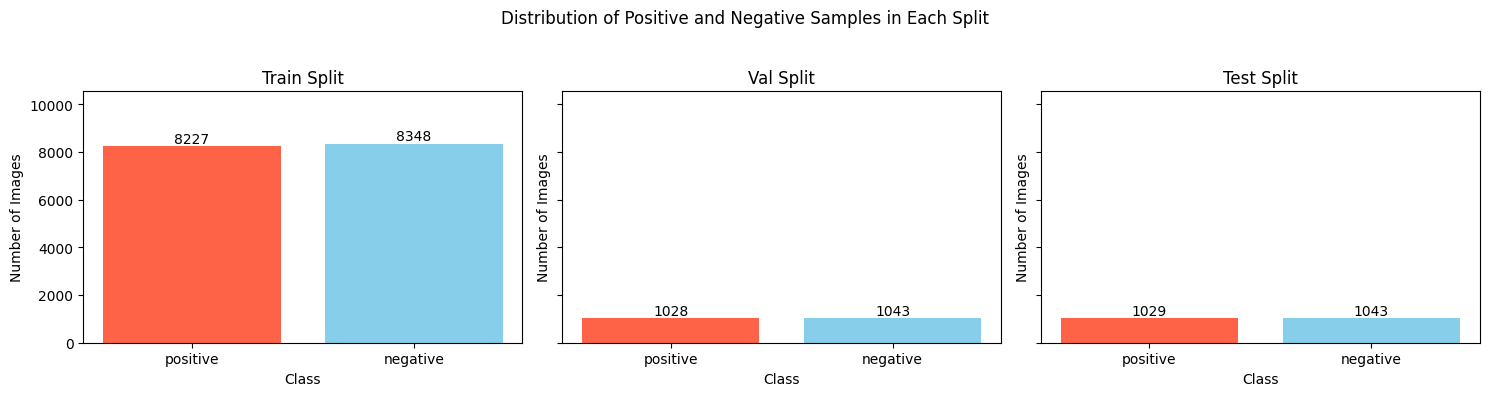

In [ ]:
# Count images in each class for each split
splits = ['train', 'val', 'test']
class_names = ['positive', 'negative']
counts = {split: {cls: 0 for cls in class_names} for split in splits}

for split in splits:
    for cls in class_names:
        dir_path = os.path.join(FINAL_DATASET_PATH, split, cls)
        if os.path.exists(dir_path):
            counts[split][cls] = len([
                f for f in os.listdir(dir_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for idx, split in enumerate(splits):
    axes[idx].bar(class_names, [counts[split][cls] for cls in class_names], color=['tomato', 'skyblue'])
    axes[idx].set_title(f'{split.capitalize()} Split')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_ylim(0, max(total_positive, total_negative) + 100)
    for i, cls in enumerate(class_names):
        axes[idx].text(i, counts[split][cls] + 10, str(counts[split][cls]), ha='center', va='bottom')

plt.suptitle('Distribution of Positive and Negative Samples in Each Split')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Data Visualization

We have displayed some sample X-ray images to understand the training data. This visualization will help us see the actual differences between normal chest X-rays and X-rays showing pneumonia.

**Differentiating factors in chest X-rays:**
- **Normal X-rays (Negative)**: Clear, dark lung areas with well-defined edges. The lungs should appear mostly black because air doesn't block X-rays much.
- **Pneumonia X-rays (Positive)**: White or cloudy patches in the lung areas where fluid or infection has accumulated. These areas appear brighter because the infected tissue blocks more X-rays than healthy air-filled lungs.

We have display 10 images from each category in a 4x5 grid - the top 2 rows will show pneumonia cases, and the bottom 2 rows will show normal cases. This layout makes it easier to compare and spot the visual differences between healthy and infected lungs.


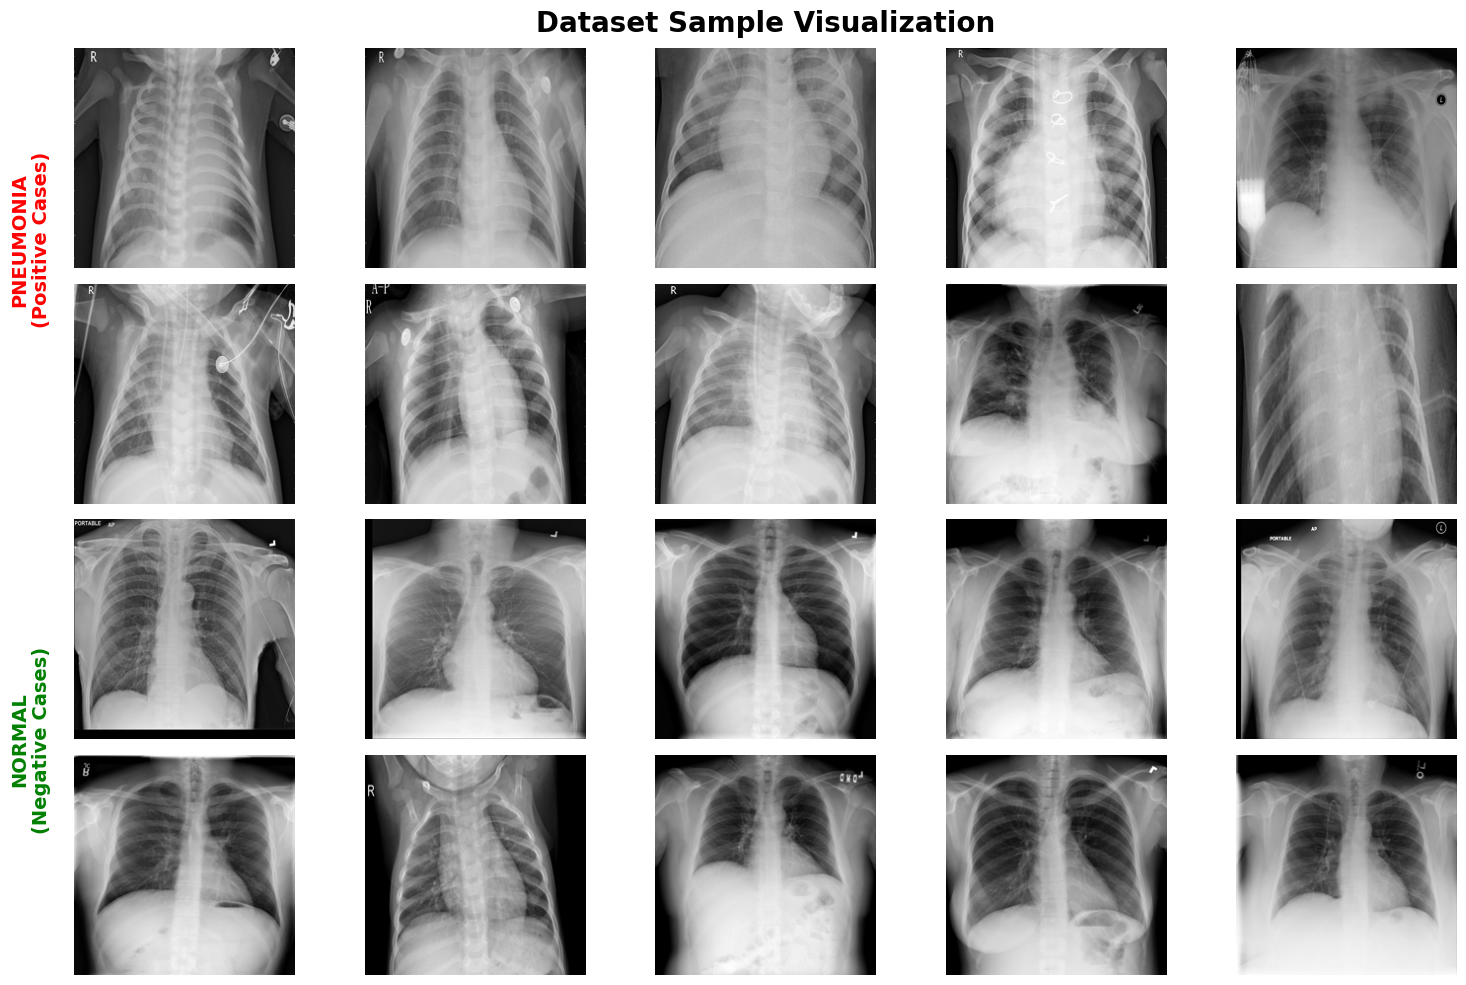

In [ ]:
FINAL_DATASET_PATH = './datasets/combined_dataset/'

# Define paths to image directories
positive_path = f'{FINAL_DATASET_PATH}/train/positive'
negative_path = f'{FINAL_DATASET_PATH}/train/negative'

# Get list of image files from both directories
positive_files = [f for f in os.listdir(positive_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
negative_files = [f for f in os.listdir(negative_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 10 samples from each class
random.seed(500)  # For reproducibility
selected_positive = random.sample(positive_files, min(10, len(positive_files)))
selected_negative = random.sample(negative_files, min(10, len(negative_files)))

# Combine both lists with labels
all_images = [(img, positive_path, 'Positive') for img in selected_positive] + \
             [(img, negative_path, 'Negative') for img in selected_negative]

# Create 4x5 subplot grid (4 rows, 5 columns)
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
fig.suptitle('Dataset Sample Visualization', fontsize=20, fontweight='bold')

# Display all images using single loop
for i, (img_file, base_path, label) in enumerate(all_images):
    # Calculate row and column indices
    row = i // 5  # 5 images per row
    col = i % 5

    # Load and resize image to square
    img_path = os.path.join(base_path, img_file)
    img = Image.open(img_path)

    # Resize to square (224x224) maintaining aspect ratio
    img = img.resize((224, 224))

    # Display image without individual titles
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].axis('off')

# Add class labels on the left side after tight_layout
plt.tight_layout()

# Add class labels with correct positioning
fig.text(0.01, 0.75, 'PNEUMONIA\n(Positive Cases)', fontsize=14, fontweight='bold',
         rotation=90, va='center', ha='center', color='red')
fig.text(0.01, 0.25, 'NORMAL\n(Negative Cases)', fontsize=14, fontweight='bold',
         rotation=90, va='center', ha='center', color='green')

plt.show()

## 3. Data Loading and Preprocessing

After organizing our datasets, we have to prepare them for model training. We have decided to use a folder-based approach that follows PyTorch's ImageFolder convention.

### Image Standardization

All models we're testing (ConvNeXt, EfficientNet, ViT, Swin Transformer) require fix size input images. Most of these models were trained on 224X224 size of images of ImageNet Dataset. Due to that reason, we have also converted all the images in 224X224 size using pytorch transformation.

### Data Augmentation Strategy

For training data, we apply medical image-appropriate augmentations to prevent overfitting:
- **Geometric**: Mild rotation (±8°), small translations (5%), and scale variations (±5%) to simulate natural X-ray positioning variations
- **Intensity**: Brightness and contrast adjustments (±10%) to mimic X-ray exposure variations
- **Horizontal flip**: Low probability (20%) since X-rays are typically standardized

These augmentations are conservative compared to natural image augmentation because aggressive transformations could create unrealistic medical artifacts.

### Normalization

We use ImageNet normalization statistics even for grayscale X-rays because all pre-trained models expect this standardization. The validation and test sets only receive resizing and normalization without augmentation to ensure consistent evaluation.

The DataLoaders use batch_size=48 with 16 workers for efficient parallel data loading and GPU memory optimization.

In [ ]:
FINAL_DATASET_PATH = './datasets/combined_dataset/'

def get_data_loaders(batch_size: int = 48, img_size: int = 224) -> tuple:
    """
    Creates PyTorch DataLoaders for pneumonia classification with medical image-appropriate transforms.

    Input: batch_size (int) - Batch size for data loading
           img_size (int) - Target size for square images
    Output: tuple - (train_loader, val_loader, test_loader, class_names)
    """

    # Define transforms for training with medical image-appropriate augmentations
    train_transform = transforms.Compose([
        # Resize to target dimensions
        transforms.Resize((img_size, img_size)),

        # Converting image into 3 channles
        transforms.Grayscale(num_output_channels=3),

        # Mild rotation (±8 degrees) - realistic for X-ray positioning variations
        transforms.RandomRotation(degrees=8),

        # Small random translation and scaling - simulates patient positioning
        transforms.RandomAffine(
            degrees=0,           # No additional rotation
            translate=(0.05, 0.05),  # 5% translation in each direction
            scale=(0.95, 1.05),      # 5% scale variation
            fill=0               # Fill with black (typical X-ray background)
        ),

        # Horizontal flip with marginal probability
        transforms.RandomHorizontalFlip(p=0.4),

        # Brightness and contrast adjustment - common in medical imaging
        transforms.ColorJitter(
            brightness=0.1,      # Mild brightness variation (10%)
            contrast=0.1,        # Mild contrast variation (10%)
            saturation=0,        # No saturation change for X-rays
            hue=0               # No hue change for X-rays
        ),

        # Convert PIL image to tensor
        transforms.ToTensor(),

        # Normalize using ImageNet statistics (standard for pretrained models)
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean for RGB channels
            std=[0.229, 0.224, 0.225]    # ImageNet std for RGB channels
        )
    ])

    # Define transforms for validation and test (no augmentation)
    eval_transform = transforms.Compose([
        # Resize to target dimensions
        transforms.Resize((img_size, img_size)),

        # Converting image into 3 channles
        transforms.Grayscale(num_output_channels=3),

        # Convert PIL image to tensor
        transforms.ToTensor(),

        # Apply same normalization as training
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Create datasets using ImageFolder
    train_dataset = datasets.ImageFolder(
        root=f'{FINAL_DATASET_PATH}/train',
        transform=train_transform
    )

    val_dataset = datasets.ImageFolder(
        root=f'{FINAL_DATASET_PATH}/val',
        transform=eval_transform
    )

    test_dataset = datasets.ImageFolder(
        root=f'{FINAL_DATASET_PATH}/test',
        transform=eval_transform
    )

    # Create data loaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,           # Shuffle training data for better learning
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,          # No shuffling needed for validation
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,          # No shuffling needed for testing
    )

    # Extract class names from dataset
    class_names = train_dataset.classes

    # Display dataset and loader information
    print("=" * 50)
    print("DataLoaders Created Successfully!")
    print("=" * 50)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Classes: {class_names}")
    print(f"Batch size: {batch_size}")
    print(f"Image size: {img_size}x{img_size}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    print("=" * 50)

    return train_loader, val_loader, test_loader, class_names

# Create data loaders with batch size 48 for pneumonia classification
train_loader, val_loader, test_loader, class_names = get_data_loaders(batch_size=48)

DataLoaders Created Successfully!
Training samples: 16575
Validation samples: 2071
Test samples: 2072
Classes: ['negative', 'positive']
Batch size: 48
Image size: 224x224
Number of training batches: 346
Number of validation batches: 44
Number of test batches: 44


### Visualization of transformation techniques

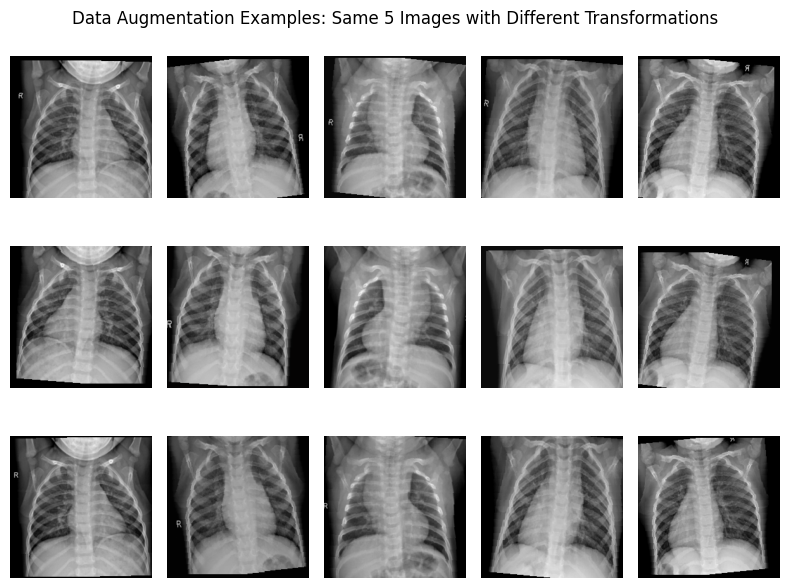

In [ ]:
# Create a new data loader with shuffle=False to get the same images each time
# We're using the same dataset but creating a new loader just to control shuffling
fixed_train_loader = DataLoader(
    train_loader.dataset,
    batch_size=5,
    shuffle=False
)

# Function to denormalize images for display
def denormalize(tensor):
    """Convert normalized tensor back to displayable image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Create a figure to display 3 rows of the same 5 images
plt.figure(figsize=(8, 10))

# Display the same 5 images 3 times (each time with different augmentations)
for row in range(3):
    # Get a new batch with the same images but different augmentations
    # (PyTorch applies transforms randomly each time)
    images, labels = next(iter(fixed_train_loader))

    # Display each image in this batch
    for i in range(5):
        plt.subplot(5, 5, row*5 + i + 1)

        # Convert tensor to displayable image
        img = denormalize(images[i])
        img = img.permute(1, 2, 0).clamp(0, 1).numpy()

        # Display the image
        plt.imshow(img)
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Data Augmentation Examples: Same 5 Images with Different Transformations", y=0.98)
plt.subplots_adjust(top=0.95)
plt.show()

In [ ]:
# recreating data loaders with batch size 48 for pneumonia classification to avoid shuffle issue
train_loader, val_loader, test_loader, class_names = get_data_loaders(batch_size=48)

DataLoaders Created Successfully!
Training samples: 16575
Validation samples: 2071
Test samples: 2072
Classes: ['negative', 'positive']
Batch size: 48
Image size: 224x224
Number of training batches: 346
Number of validation batches: 44
Number of test batches: 44


## 4. Training different CNN models

### Training Strategy

We have utilized several new techniques for training CNN models:

- **AdamW optimizer** with weight decay (0.02) for L2 regularization to prevent overfitting
- **Cosine Annealing scheduler** for smooth learning rate decay from 0.001 to 1e-6
- **BCEWithLogitsLoss** combining sigmoid activation with binary cross-entropy for numerical stability

The training function tracks loss, accuracy, and learning rate throughout training, automatically saving the best model based on validation performance. After training, it generates comprehensive visualization plots showing loss curves, accuracy trends, learning rate schedule, and overfitting analysis.


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs: int = 50, learning_rate: float = 0.001,
                weight_decay: float = 0.02, checkpoint_dir: str = './checkpoints',
                model_name: str = 'efficientnetv2', batch_size: int = 48) -> None:
    """
    Trains the model with validation monitoring and checkpoint saving.

    Input: model - PyTorch model to train
           train_loader - Training data loader
           val_loader - Validation data loader
           num_epochs (int) - Number of training epochs
           learning_rate (float) - Initial learning rate
           weight_decay (float) - Weight decay for AdamW optimizer
           checkpoint_dir (str) - Base directory to save model checkpoints
           model_name (str) - Name prefix for saved models
           batch_size (int) - Batch size for filename identification
    Output: None
    """

    # Create model-specific checkpoint directory with hyperparameters
    model_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)

    # Generate timestamp for unique model identification
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Move model to appropriate device (GPU/CPU)
    model = model.to(DEVICE)

    # Define loss function for binary classification
    criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid + BCE for numerical stability

    # Initialize AdamW optimizer with weight decay (L2 regularization)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Cosine Annealing scheduler - smoothly decreases learning rate
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    # Initialize metrics tracking dictionary
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rate': []
    }

    # Track best validation accuracy for model saving
    best_val_acc = 0.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Model: {model_name} | LR: {learning_rate} | Batch Size: {batch_size} | Weight Decay: {weight_decay}")
    print("=" * 80)

    # Training loop
    for epoch in range(num_epochs):
        epoch_start = time.time()
        current_lr = optimizer.param_groups[0]['lr']

        # ==================== TRAINING PHASE ====================
        model.train()  # Set model to training mode (enables dropout, batch norm training)
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training loop with progress bar
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')):
            # Move data to device
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.float().to(DEVICE, non_blocking=True)

            # Zero gradients from previous iteration
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).squeeze()  # Remove extra dimensions
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate batch accuracy
            predictions = torch.sigmoid(outputs) > 0.5
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
            train_loss += loss.item()

        # Calculate average training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # ==================== VALIDATION PHASE ====================
        model.eval()  # Set model to evaluation mode (disables dropout, batch norm training)
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Validation loop without gradient computation
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                # Move data to device
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.float().to(DEVICE, non_blocking=True)

                # Forward pass only
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                # Calculate batch accuracy
                predictions = torch.sigmoid(outputs) > 0.5
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
                val_loss += loss.item()

        # Calculate average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Update learning rate scheduler
        scheduler.step()

        # Store metrics in history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['learning_rate'].append(current_lr)

        # Display epoch results
        epoch_time = time.time() - epoch_start
        print(f"\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s - LR: {current_lr:.2e}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
        print("-" * 80)

        # Save best model checkpoint with hyperparameters in filename
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy

            # Create descriptive filename with hyperparameters
            checkpoint_filename = f"{model_name}_lr{learning_rate}_bs{batch_size}_wd{weight_decay}_ep{epoch+1}_{timestamp}.pth"
            checkpoint_path = os.path.join(model_dir, checkpoint_filename)

            # Save only model state dict (not optimizer, history, etc.)
            torch.save(model.state_dict(), checkpoint_path)

            print(f"✓ Saved best model: {checkpoint_filename}")
            print(f"  Validation accuracy: {val_accuracy:.2f}%")

    # Training completion summary
    print("\n" + "=" * 80)
    print(f"Training completed successfully!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"Model saved in: {model_dir}")
    print("=" * 80)

    # Plot training history
    plot_training_history(history, model_name)


def plot_training_history(history: dict, model_name: str = 'Model') -> None:
    """
    Plots comprehensive training and validation metrics.

    Input: history (dict) - Dictionary containing training metrics
           model_name (str) - Name of the model for plot titles
    Output: None
    """
    # Create subplot grid for multiple metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot training and validation loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss', fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot training and validation accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy', fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot learning rate schedule
    ax3.plot(epochs, history['learning_rate'], 'g-', label='Learning Rate', linewidth=2)
    ax3.set_title('Learning Rate Schedule (Cosine Annealing)', fontweight='bold')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')  # Log scale for better visualization
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot accuracy difference to check overfitting
    accuracy_diff = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
    ax4.plot(epochs, accuracy_diff, 'purple', linewidth=2, label='Train - Val Accuracy')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No Difference')
    ax4.set_title('Overfitting Check (Train - Val Accuracy)', fontweight='bold')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy Difference (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Add color zones for overfitting interpretation
    ax4.axhspan(-5, 5, alpha=0.1, color='green', label='Good Generalization')
    ax4.axhspan(5, 15, alpha=0.1, color='yellow')
    ax4.axhspan(15, max(accuracy_diff) if max(accuracy_diff) > 15 else 20, alpha=0.1, color='red')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [ ]:
def create_cnn_model(model_name: str, num_classes: int = 1, pretrained: bool = True,
                               dropout_rate: float = 0.3, drop_path_rate: float = 0.0) -> nn.Module:
    """
    Creates CNN model optimized for classification.

    Input:
           model_name (str) - Name of CNN model
           num_classes (int) - Number of output classes (1 for binary classification)
           pretrained (bool) - Use ImageNet pretrained weights for transfer learning
           dropout_rate (float) - Dropout probability for regularization
           drop_path_rate (float) - regularization parameter to control stochastic depth (randomly dropping entire layers during training)
    Output: nn.Module - CNN model with modified classifier head
    """
    # Create CNN model with custom classifier head
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes,  # Automatically creates appropriate classifier
        drop_rate=dropout_rate,    # Built-in dropout in classifier
        drop_path_rate=drop_path_rate # Stochastic depth throughout the network
    )

    # Display model statistics
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"CNN Model Created:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Output classes: {num_classes}")
    print(f"  Pretrained: {pretrained}")

    return model

### Model Training and Selection Strategy

In this project, we will begin by training four different deep learning models using our curated training dataset. Our objective is to identify which model architecture performs best for the pneumonia detection task before proceeding to hyperparameter tuning. The initial phase will focus on EfficientNet, where we will experiment with both the medium (EfficientNetV2-M) and small (EfficientNetV2-S) variants with default hyperparameters (. This approach allows us to assess how model size and parameter count impact classification accuracy.

For EfficientNet architecture, we will also investigate the impact of transfer learning by comparing training runs that utilize ImageNet pre-trained weights with those that do not. This will help us determine whether leveraging external knowledge improves model accuracy for our specific medical imaging task.

Once we have established baseline results with EfficientNet, we will select models from other leading architectures—ConvNeXt, Vision Transformer (ViT), and Swin Transformer—that have a comparable number of parameters to our chosen EfficientNet variant. This ensures a fair comparison between architectures in terms of computational complexity and resource usage. We will decide the use of transfer learning for these models from EfficientNet results.

We selected EfficientNet, ConvNeXt, ViT, and Swin Transformer for our experiments because these architectures have achieved outstanding accuracy on the ImageNet benchmark.

Due to the computational demands and long training times associated with these models, an exhaustive hyperparameter search is not feasible. Instead, after identifying the most promising architecture based on initial results, we will focus our hyperparameter tuning efforts on that model alone. This targeted approach maximizes our chances of achieving optimal performance within our available resources.


### EfficientNetV2-M

We have started our experiments with EfficientNetV2-M, the medium variant of the EfficientNetV2 family, as our baseline convolutional neural network architecture. EfficientNetV2 introduces several improvements over the original EfficientNet, including faster training and greater parameter efficiency. The medium variant is selected to balance model performance with the constraints of our 16GB GPU memory. For the binary pneumonia classification task, we have adapted the final layer of the architecture to output a single value, corresponding to the probability of pneumonia.


In [ ]:
# Create optimized EfficientNetV2 model
efficientnet_model = create_cnn_model(model_name = "tf_efficientnetv2_m", num_classes=1, pretrained=True)

# Train the EfficientNetV2 model
train_model(
    model=efficientnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=0.00005,
    weight_decay=0.0001,
    checkpoint_dir='./checkpoints',
    model_name='efficientnetv2_m',
    batch_size=48
)

# Clearing the memory for next training
del efficientnet_model
torch.cuda.empty_cache()
gc.collect()

CNN Model Created:
  Total parameters: 52,859,637
  Trainable parameters: 52,859,637
  Output classes: 1
  Pretrained: True
Starting training for 30 epochs...
Model: efficientnetv2_m | LR: 5e-05 | Batch Size: 48 | Weight Decay: 0.0001


Epoch 1/30 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:23<00:00,  1.90it/s]



Epoch [1/30] - Time: 252.22s - LR: 5.00e-05
Train Loss: 1.0032 | Train Acc: 87.70%
Val Loss: 0.5256 | Val Acc: 86.43%
--------------------------------------------------------------------------------
✓ Saved best model: efficientnetv2_m_lr5e-05_bs48_wd0.0001_ep1_20251126_192416.pth
  Validation accuracy: 86.43%


Epoch 2/30 - Training:   2%|██▏                                                                                                       | 7/346 [00:04<03:29,  1.62it/s]

### EfficientNetV2-Small

Next, we train the EfficientNetV2-Small (tf_efficientnetv2_s) model on our pneumonia detection dataset. This smaller variant has fewer parameters than the medium model, allowing us to evaluate the trade-off between model size and classification accuracy. We use the same training configuration as before to ensure a fair comparison.

In [ ]:
# Create EfficientNetV2-Small model
efficientnet_small_model = create_cnn_model(
    model_name="tf_efficientnetv2_s",
    num_classes=1,
    pretrained=True
)

# Train the EfficientNetV2-Small model
train_model(
    model=efficientnet_small_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=0.00005,
    weight_decay=0.0001,
    checkpoint_dir='./checkpoints',
    model_name='efficientnetv2_s',
    batch_size=48
)

# Clear memory before training the next model
del efficientnet_small_model
torch.cuda.empty_cache()
gc.collect()

### Training EfficientNetV2-Small Without Pretrained Weights

To assess the impact of transfer learning, we also train the EfficientNetV2-Small model from scratch, without using pretrained ImageNet weights. This experiment allows us to directly compare the benefits of initializing with external knowledge versus learning all features solely from our pneumonia dataset. By evaluating both approaches under the same training conditions, we can determine whether pretrained weights offer a significant advantage for this medical imaging task.

In [ ]:
# Create EfficientNetV2-Small model
efficientnet_small_model = create_cnn_model(
    model_name="tf_efficientnetv2_s",
    num_classes=1,
    pretrained=False # Not using pre-trained weights
)

# Train the EfficientNetV2-Small model
train_model(
    model=efficientnet_small_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=0.00005,
    weight_decay=0.0001,
    checkpoint_dir='./checkpoints',
    model_name='efficientnetv2_s',
    batch_size=48
)

# Clear memory before training the next model
del efficientnet_small_model
torch.cuda.empty_cache()
gc.collect()